# Brain Tumor Classification with Neural Networks

### Objective
This project aims to develop skills in training neural networks to classify tumors in brain MRI scans. Participants will construct and optimize neural network architectures through techniques like transfer learning and custom convolutional layers. Additionally, the project will incorporate the Gemini 1.5 Flash model to generate interpretable explanations for model predictions, enhancing both accuracy and transparency in tumor classification.

### What is a Brain Tumor?
A brain tumor is a mass of abnormal cells within the brain. Given that the brain is encased in a rigid skull, any growth in this limited space can create pressure, leading to potential complications. Brain tumors may be cancerous (malignant) or noncancerous (benign), and as they grow, they can elevate pressure within the skull, potentially causing brain damage and posing serious health risks.

![tumor.png](attachment:9968c517-fdeb-48b1-a635-0382ca5a0240.png)

* **Glioma**: They can make nearby brain areas look swollen and may have dark spots in the center if the tissue is damaged.
* **Meningioma**: They are appear with well-defined rounded mass growing on the outer layer of the brain (the meninges). These are usually rounded tumors growing on the outer layer of the brain (the meninges). They stand out clearly on scans with smooth, well-defined edges and can appear to "stick" to the lining of the brain.
* **Pituitary**: Located at the base of the brain, these tumors affect the pituitary gland. They generally look uniform and bright on scans, and they can push against nearby areas like the nerves for vision.
* **Normal**: Shows a balanced, symmetrical appearance with no lumps, swelling, or unusual bright spots, indicating no tumors or abnormal growths.

### Why This Matters*
Early detection and accurate classification of brain tumors are vital areas of research in medical imaging. Prompt identification of tumor types allows for the most effective treatment approach, which is critical to improving outcomes and potentially saving patients’ lives.



**Source:**
* [Kaggle Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
* [Kaggle: CNN Brain Tumor Classification by guslovesmath](https://www.kaggle.com/code/guslovesmath/cnn-brain-tumor-classification-99-accuracy)
* [Kaggle: Brain Tumor MRI Accuracy 99% by yousef mohamed](https://www.kaggle.com/code/yousefmohamed20/brain-tumor-mri-accuracy-99)
* [Youtube: What is neural network](https://www.youtube.com/watch?v=aircAruvnKk)
* [Youtube: How Neural Networks Learn](https://www.youtube.com/watch?v=IHZwWFHWa-w)
* [Youtube: What is a convolution](https://www.youtube.com/watch?v=KuXjwB4LzSA)
* [Interactive CNN Explainer](https://poloclub.github.io/cnn-explainer/)
* [Youtube: How Tesla uses Neural Networks to Power Self Driving](https://www.youtube.com/watch?v=FnFksQo-yEY)
* [What is Transfer Learning](https://builtin.com/data-science/transfer-learning)
* [Medium: Explainable AI: Saliency Maps](https://www.youtube.com/watch?v=FnFksQo-yEY)
* [Medium: Review on Xception](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 137M/149M [00:01<00:00, 95.3MB/s]
100% 149M/149M [00:01<00:00, 95.0MB/s]


# Utility functions

In [30]:
def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.scandir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to respective lists
        classes.append(label.name)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

def display_history(hist):
  metrics = ['accuracy', 'loss', 'precision', 'recall']
  train_metrics = {
      m: hist.history[m] for m in metrics
  }
  val_metrics = {
      m: hist.history[f'val_{m}'] for m in metrics
  }

  # Find best epochs and values
  best_epochs = {}
  best_values={}
  for m in metrics:
    if m == 'loss':
      idx = np.argmin(val_metrics[m])
    else:
      idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

  # Plot metrics
  plt.figure(figsize=(20, 12))
  plt.style.use('fivethirtyeight')

  for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(train_metrics[metric]) + 1)

    plt.plot(epochs, train_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

  plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
  plt.show()

def evaluation_report(model, train, valid, test):
  train_score = model.evaluate(train, verbose=1)
  valid_score = model.evaluate(valid, verbose=1)
  test_score = model.evaluate(test, verbose=1)


  print(f'Train Accuracy: {train_score[1]*100:.2f}%')
  print(f'Train Loss: {train_score[0]*100:.4f}%')

  print(f'Validation Accuracy: {valid_score[1]*100:.2f}%')
  print(f'Validation Loss: {valid_score[0]*100:.4f}%')

  print(f'Test Accuracy: {test_score[1]*100:.2f}%')
  print(f'Test Loss: {test_score[0]*100:.4f}%')

def display_confusion_matrix(model, dataset):
  preds = model.predict(dataset)
  y_pred = np.argmax(preds, axis=1)

  class_dict = {
      0: 'glioma',
      1: 'meningioma',
      2: 'no_tumor',
      3: 'pituitary'
  }

  # Then create and display the confusion matrix
  cm = confusion_matrix(dataset.classes, y_pred)
  labels = list(class_dict.keys())
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

In [31]:
train_path = '/content/Training'

raw_df = get_class_paths(train_path)
raw_df

,Class Path,Class
0,/content/Training/meningioma/Tr-me_1113.jpg,meningioma
1,/content/Training/meningioma/Tr-me_0551.jpg,meningioma
2,/content/Training/meningioma/Tr-me_0451.jpg,meningioma
3,/content/Training/meningioma/Tr-me_0721.jpg,meningioma
4,/content/Training/meningioma/Tr-me_0289.jpg,meningioma
...,...,...
5707,/content/Training/glioma/Tr-gl_1192.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0679.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0999.jpg,glioma
5710,/content/Training/glioma/Tr-gl_1062.jpg,glioma


In [32]:

test_path = '/content/Testing'

test_raw_df = get_class_paths(test_path)
test_raw_df

,Class Path,Class
0,/content/Testing/meningioma/Te-me_0054.jpg,meningioma
1,/content/Testing/meningioma/Te-me_0044.jpg,meningioma
2,/content/Testing/meningioma/Te-me_0167.jpg,meningioma
3,/content/Testing/meningioma/Te-me_0262.jpg,meningioma
4,/content/Testing/meningioma/Te-me_0057.jpg,meningioma
...,...,...
1306,/content/Testing/glioma/Te-gl_0108.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0148.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0121.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0014.jpg,glioma


# Visualization

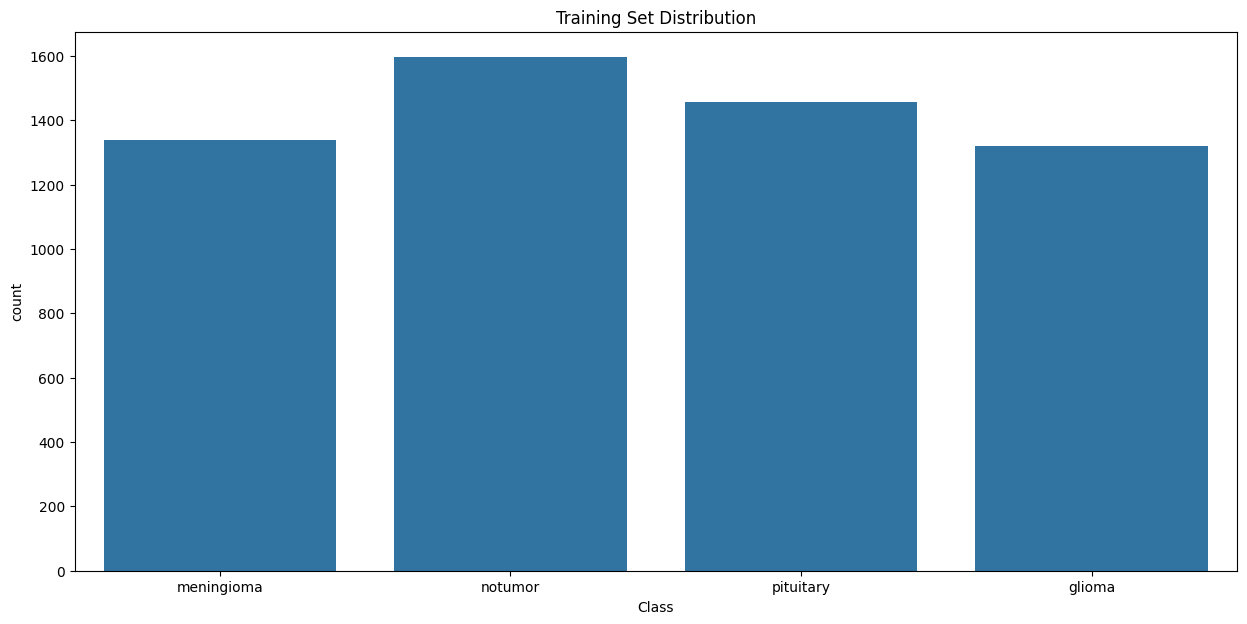

In [33]:
plt.figure(figsize=(15, 7))
plt.title("Training Set Distribution")
ax = sns.countplot(data=raw_df, x=raw_df['Class'])

**Observation**: The dataset looks fairly balanced which means that each tumor labels have fair amount of data. This tells us that we don't need to apply sampling techniques

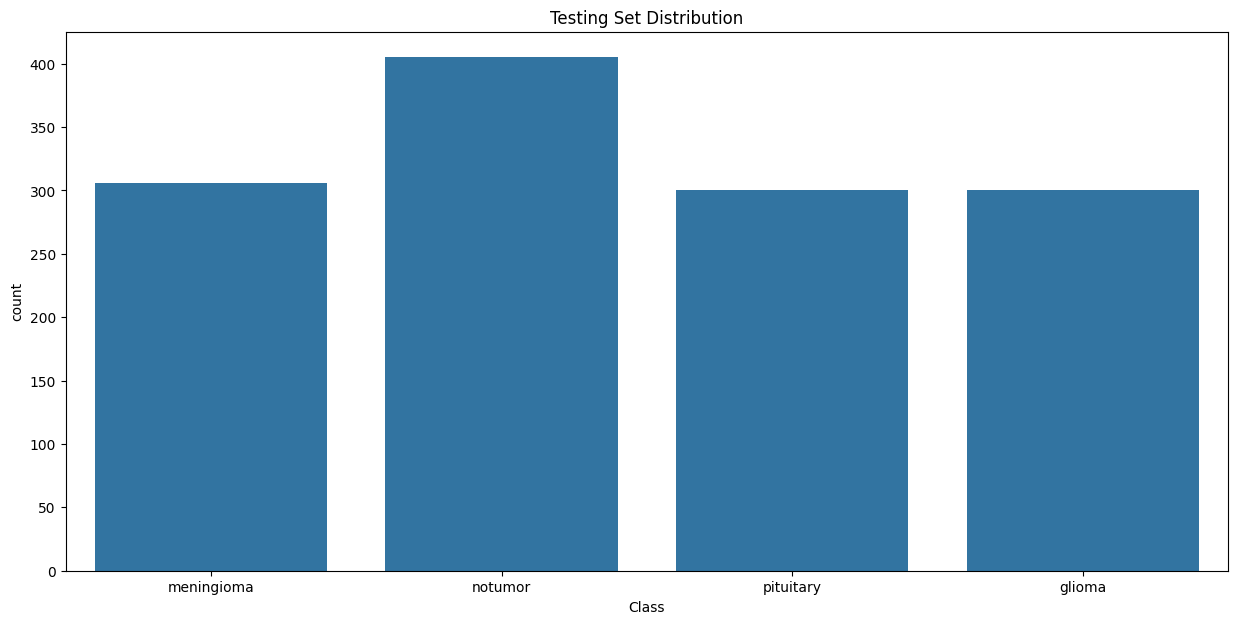

In [34]:
plt.figure(figsize=(15, 7))
plt.title("Testing Set Distribution")
ax = sns.countplot(data=test_raw_df, x=test_raw_df['Class'])

# Split Data

In [35]:
valid_df, test_df = train_test_split(test_raw_df, train_size=0.5, stratify=test_raw_df['Class'])
print(valid_df.shape, test_df.shape)

(655, 2) (656, 2)


# Resize Data

NOTE: ImageDataGenerator is deprecated.

# TODO: Update this later. [keras image](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image)

In [36]:
BATCH_SIZE = 32
IMAGE_SIZE = (299, 299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
train_img_gen = image_generator.flow_from_dataframe(
    raw_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )
valid_img_gen = train_img_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [37]:
test_image_generator = ImageDataGenerator(rescale=1/255)
test_img_gen = test_image_generator.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=IMAGE_SIZE,
    shuffle=False
  )

Found 656 validated image filenames belonging to 4 classes.


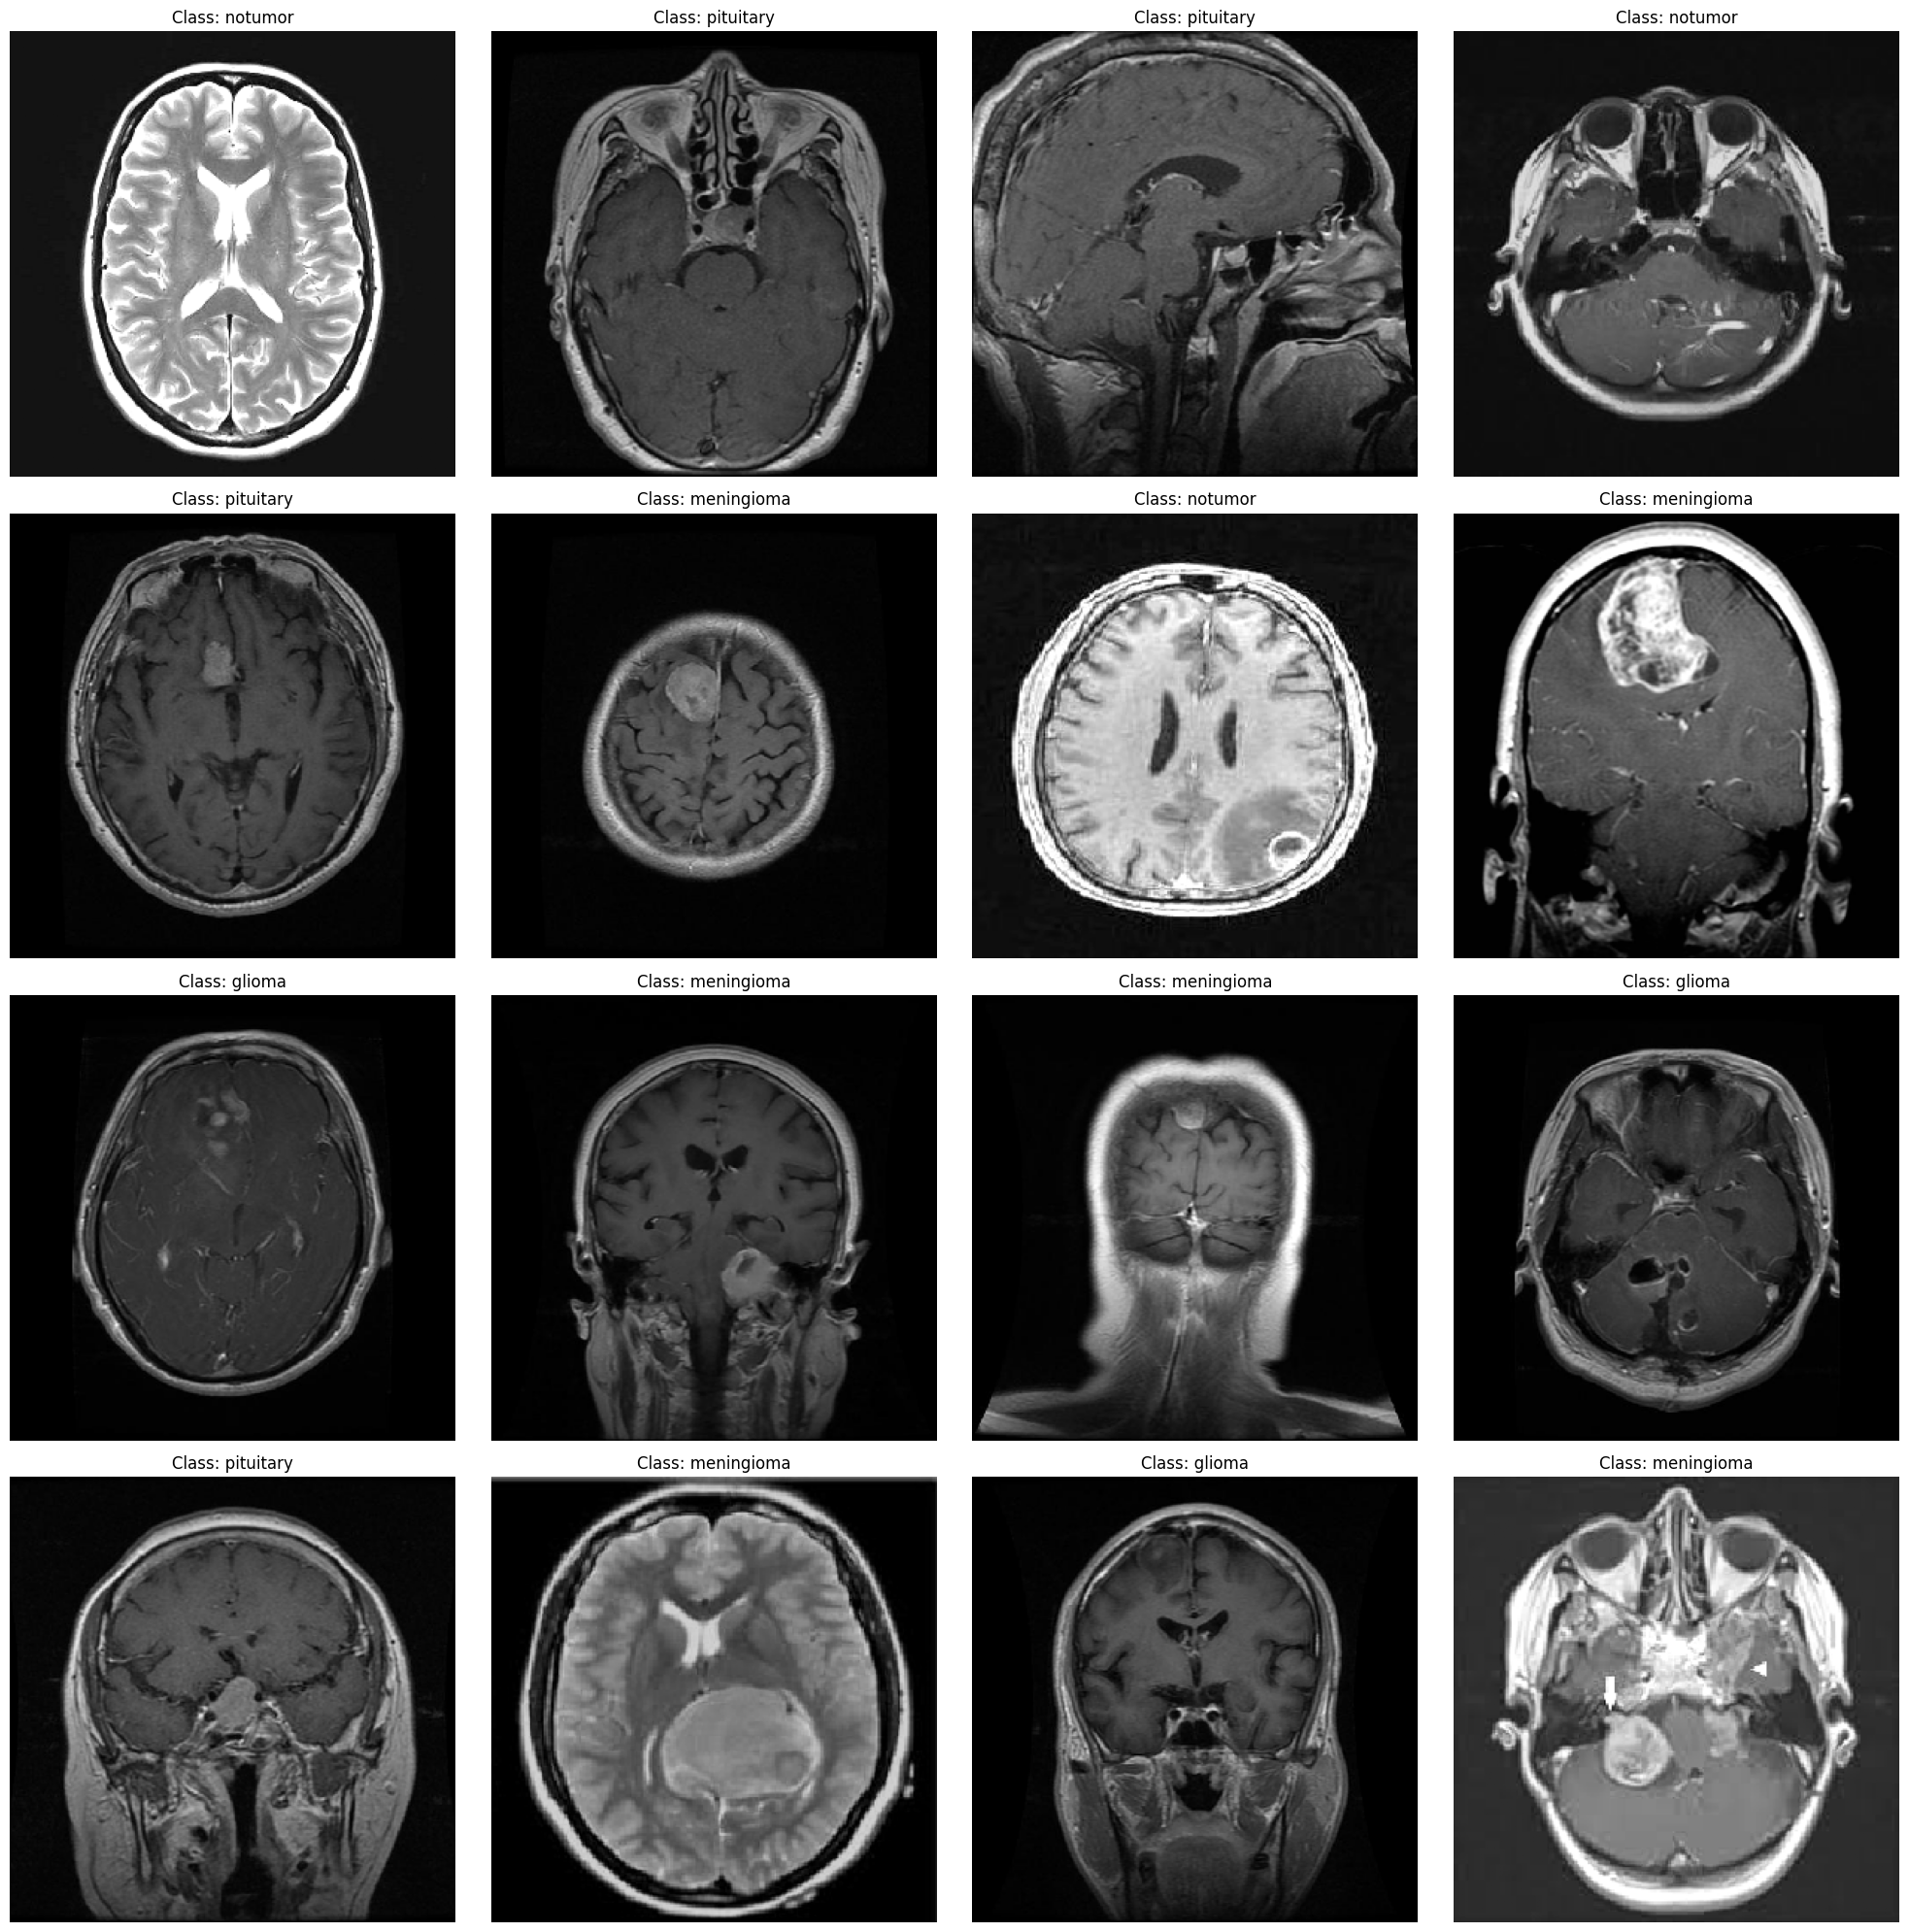

In [38]:
plt.figure(figsize=(20, 20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  batch = next(train_img_gen)
  image=batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  # Get the list of class names and class indices
  class_names = list(train_img_gen.class_indices.keys())
  class_indices = list(train_img_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f'Class: {class_name}')
  plt.axis('off')
plt.tight_layout()
plt.show()


img: 1
img: 2
img: 3
Backpropagation so the model can learn.

img: 4 How does our Xception work. This process is called Transfer learning.

Dimension reduction

img: 5. Learning rate

img 6: Categorical crossentropy Loss

img 7


In [39]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
  )

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall()
    ]
  )

# Training model
Change the runtime. go to `Runtime`, `Change Runtime type`

In [ ]:
hist = model.fit(train_img_gen, epochs=8, validation_data=valid_img_gen)

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1455s 68s/step - accuracy: 0.4890 - loss: 1.6066 - precision: 0.5496 - recall: 0.2640 - val_accuracy: 0.5679 - val_loss: 1.8626 - val_precision: 0.5944 - val_recall: 0.5527
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 1377s 66s/step - accuracy: 0.9127 - loss: 0.2401 - precision: 0.9178 - recall: 0.8981 - val_accuracy: 0.7298 - val_loss: 0.9895 - val_precision: 0.7402 - val_recall: 0.7221
Epoch 3/8
11/21 ━━━━━━━━━━━━━━━━━━━━ 8:54 53s/step - accuracy: 0.9607 - loss: 0.1257 - precision: 0.9606 - recall: 0.9574

In [ ]:
display_history(hist)

# Evaluation

In [ ]:
evaluation_report(model, train_img_gen, valid_img_gen, test_img_gen)

In [ ]:
display_confusion_matrix(model, test_img_gen)

In [ ]:
from PIL import Image

# Display the MRI image and show the confidence level of prediction
def predict(img_path: str) -> None:
  # Get class labels
  labels = list(class_dict.keys())

  # Create figure
  plt.figure(figsize=(6, 8))

  # Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299, 299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  # Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f'Input MRI Image\nPredicted: {predicted_class}')

  # Plot prediction probabilities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel('Probability', fontsize=15)
  plt.title('Class Probabilities')

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show

  print(f'\nPredicted tumor type: {predicted_class}')

In [ ]:
predict('/content/Testing/meningioma/Te-meTr_0005.jpg')

In [ ]:
model.save_weights('xception_model.weights.h5')

# Model Architecture: CNN (Convolutional Neural Networks)

img 8: Xception model vs custom CNN model

img 9: Deploying models

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
train_img_gen = image_generator.flow_from_dataframe(
    raw_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )
valid_img_gen = train_img_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )

test_image_generator = ImageDataGenerator(rescale=1/255)
test_img_gen = test_image_generator.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=IMAGE_SIZE,
    shuffle=False
  )

In [ ]:
# Create a Sequential model
cnn_model = Sequential()

# Convolutional layers
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

# Output 4 neurons for 4 classes
cnn_model.add(Dense(4, activation='softmax'))

# Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics= ['accuracy', Precision(), Recall()])

# Display the model summary
cnn_model.summary()

In [ ]:
history = cnn_model.fit(train_img_gen, epochs=8, validation_data=valid_img_gen)

In [ ]:
display_history(history)

In [ ]:
evaluation_report(cnn_model, train_img_gen, valid_img_gen, test_img_gen)

In [ ]:
display_confusion_matrix(cnn_model, test_img_gen)

In [ ]:
predict('/content/Testing/meningioma/Te-meTr_0005.jpg')
model.save_weights('cnn_model.weights.h5')

# Part 2: Streamlit Web App

In [3]:
!pip install streamlit pyngrok python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.7 MB/s eta 0:00:00


In [9]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [14]:
ngrok_token = userdata.get(NGROK_AUTH_TOKEN)
ngrok.set_auth_token(ngrok_token)

NameError: name 'NGROK_AUTH_TOKEN' is not defined

In [12]:
def run_streamlit():
  os.system('streamlit run /content/app.py --server.port 8501')

In [22]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.model import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

import google.generativeai as genai
import PIL.Image
import os
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()



genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)

def generate_explanation(img_path, model_prediction, confidence):
  prompt = f"""
    You are a n expert neurologist. You are tasked with explaning a saliency map of a brain tumor MRI scan.
    The saliency map was generated by a deep learning model that was trained to classify brain tumors
    as either glioma, meningioma, pituitary, or no tumor.

    The saliency map highlights the regions of the image that the machine learning model is focusing on to make the prediction.

    The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence * 100}%.

    In your response:
    - Explain what regions of the brain the model is focusing on, based on teh saliency map. Refer to the regions highlighted
    in light cyan, those are the regions where the model is focusing on.
    - Explain possible reasons why the model made the prediction it did.
    - Don't mention anything like 'The saliency map highlights the regions the model is focusing on, which are in light cyan'
    in your explanation.
    - Keep your explanation to 4 sentences max.

    Let's think step by step about this. Verify step by step.
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name='gemini-1.5-flash')
  response = model.generate_content([prompt, img])
  return response.text

def generate_saliency_map(model, img_array, class_index, img_size):
  with tf.GradientTape() as tape:
    img_tensor = tf.convert_to_tensor(img_array)
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    target_class = predictions[:, class_index]

  gradients = tape.gradient(target_class, img_tensor)
  gradients = tf.math.abs(gradients)
  gradients = tf.reduce_max(gradients, axis=-1)
  gradients = gradients.numpy().squeeze()

  # Resize gradients to match original image size
  gradients = cv2.resize(gradients, img_size)

  # Create a circular mask for the brain area
  center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
  radius = min(center[0], center[1]) - 10
  y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
  mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

  # Apply mask to gradients
  gradients = gradients * mask

  # Normalize only the brain area
  brain_gradients = gradients[mask]
  if brain_gradients.max() > brain_gradients.min():
    gradients = (gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
  gradients[mask] = brain_gradients

  # Apply a higher threshold
  threshold = np.percentile(gradients[mask], 80)
  gradients[gradients < threshold] = 0

  # Apply more aggressive smoothing
  gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

  # Create a heatmap overlay with enhanced contrast
  heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  # Resize heatmap to match original image size
  heatmap = cv2.resize(heatmap, img_size)

  # Superimpose the heatmap on original image with increased opacity
  original_img = image.img_to_array(img)
  superimposed_img = heatmap * 0.7 + original_img * 0.3
  superimposed_img = superimposed_img.astype(np.uint8)

  img_path = os.path.join(output_dir, uploaded_file.name)
  with open(img_path, 'wb') as f:
    f.write(uploaded_file.getbuffer())

  saliency_map_path = f'saliency_maps/{uploaded_file.name}'

  # Save the saliency map
  cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

  return superimposed_img


def load_xception_model(model_path):
  img_shape=(299, 299, 3)
  base_model = tf.keras.application.Xception(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

  model = Sequential([
      base_model,
      Flatten(),
      Dropout(rate=0.3),
      Dense(128, activation='relu'),
      Dropout(rate=0.25),
      Dense(4, activation='softmax')
  ])

  model.build((None, ) + img_shape)

  # Compile the model
  model.compile(Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()
  ])

  model.load_weights(model_path)

  return model

st.title('Brain Tumor Classification')
st.write('Upload an image of a brain MRI scan to classify.')
uploaded_file = st.file_uploader('Choose an image...', type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:

  selected_model = st.radio(
      'Select Model',
      ('Transfer Learning - Xception', 'Custom CNN')
  )

  if selected_model == 'Transfer Learning - Xception':
    model = load_model('/content/xception_model.weights.h5')
    img_size = (299, 299)
  else:
    model = load_model('/content/cnn_model.h5')
    img_size = (224, 224)

  labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
  img = image.load_img(uploaded_file, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)

  # Get the class with the highest probability
  predicted_class_idx = np.argmax(prediction[0])
  predicted_class = labels[predicted_class_idx]

  st.write(f'Predicted Tumor Type: {predicted_class}')
  st.write('Prediction Probabilities:')

  for label, prob in zip(labels, prediction[0]):
    st.write(f'{label}: {prob * 100:.4f}%')

  saliency_map = generate_saliency_map(model, img_array, predicted_class_idx, img_size)

  col1, col2 = st.columns(2)

  with col1:
    st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)
  with col2:
    st.image(saliency_map, caption='Saliency Map', use_column_width=True)

  st.write('## Clasification Results')

  result_container = st.container()
  result_container = st.container()
  result_container.markdown(
      f"""
      <div style='background-color: #000; color: #fff; padding: 30px; border-radius: 15px;;'>
        <div style='display: flex; justify-content: space-between; align-items: center;'>
          <div style='flex: 1, text-align: center;'>
            <h3 style='color: #fff; margin-bottom: 10px; font-size: 20px;'>Prediction</h3>
            <p style='font-size: 36px; font-weight: 800; color: #ff0000; margin: 0;'>
              {result}
            </p>
          </div>

          <div style='width: 2px; height: 80px; background-color: #fff; margin: 0 20px;'></div>
          <div style='flex: 1; text-align: center;'>
            <h3 style='color: #fff; margin-bottom: 10px; font-size: 20px;'>Confidence</h3>
            <p style='font-size: 36px; font-weight: 800; color: #2196F3; margin: 0;'>
              {prediction[0][class_index]:.4%}
            </p>
          </div>
          </div>
        </div>
      """,
      unsafe_allow_html=True
  )

  saliency_map_path = f'saliency_maps/{uploaded_file.name}'
  explanation = generate_explanation(saliency_map_path, predicted_class, prediction[0][predicted_class_idx])

  st.write('Explanation:')
  st.write(explanation)

Overwriting app.py


In [19]:
# Thread allows to run the programs in parallel.
thread = Thread(target=run_streamlit)
thread.start()

Exception in thread Thread-12 (run_streamlit):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-36b14eb2028a>", line 2, in run_streamlit
NameError: name 'os' is not defined


In [21]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print('Public URL:', public_url)

ERROR:pyngrok.process.ngrok:t=2024-11-08T08:19:55+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-11-08T08:19:55+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-11-08T08:19:55+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [23]:
tunnels = ngrok.get_tunnels()

for tunnel in tunnels:
  print(f'Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}')
  ngrok.disconnect(tunnel.public_url)

SyntaxError: f-string: unmatched '[' (<ipython-input-23-242c778db618>, line 4)